In [18]:
import numpy as np
from scipy.stats import johnsonsu, skew, kurtosis as scipy_kurtosis
from scipy.optimize import root
import matplotlib.pyplot as plt

In [19]:
def _moment_equations(params, target_skew, target_kurt):
    """
    Equations for root finding. We want the skewness and kurtosis
    of a Johnson SU distribution (with loc=0, scale=1) to match targets.
    """
    a, b = params
    if b <= 0:  # b must be positive for Johnson SU
        return [1e6, 1e6] # Return large error if b is invalid

    # SciPy's johnsonsu.stats returns (mean, variance, skewness, excess_kurtosis)
    try:
        # Forcing loc=0 and scale=1 to isolate shape parameters a and b
        mean_jsu, var_jsu, skew_jsu, kurt_jsu = johnsonsu.stats(a, b, loc=0, scale=1, moments='mvsk')
        
        # Handle cases where moments might not be defined for certain a, b or var is non-positive
        if np.isnan(skew_jsu) or np.isnan(kurt_jsu) or var_jsu <= 0 or np.isinf(skew_jsu) or np.isinf(kurt_jsu):
            return [1e6, 1e6]
            
    except (ValueError, FloatingPointError) as e: # Catch errors during moment calculation
        # print(f"Warning: Error calculating moments for a={a}, b={b}: {e}")
        return [1e6, 1e6]

    err_skew = skew_jsu - target_skew
    err_kurt = kurt_jsu - target_kurt
    return [err_skew, err_kurt]

In [20]:
def _find_johnsonsu_params(target_skew, target_kurtosis):
    """
    Finds the Johnson SU parameters 'a' and 'b' that best match
    the target skewness and kurtosis.
    """
    # Check if the target skewness and kurtosis are achievable by Johnson SU
    # Condition: kurtosis > skewness^2 - 2
    if target_kurtosis <= target_skew**2 - 2:
        print(f"Warning: Target kurtosis ({target_kurtosis}) and skewness ({target_skew}) may not be achievable "
              f"by Johnson SU distribution (kurtosis > skewness^2 - 2 is not met). "
              f"The results might not be accurate.")
        # Proceeding anyway, but the optimization might fail or give poor results.

    # Initial guess for a and b.
    # 'a' influences skewness, 'b' influences kurtosis.
    # A common starting point.
    initial_guess = [target_skew if target_skew != 0 else 0.01 , np.sqrt(2*target_kurtosis + 4) if target_kurtosis > -1.9 else 2.0] 
    if initial_guess[1] <=0: initial_guess[1] = 2.0 # Ensure b_guess is positive
    
    # print(f"Initial guess for (a,b): {initial_guess}")

    solution = root(_moment_equations, initial_guess, args=(target_skew, target_kurtosis), method='lm', tol=1e-6)
    
    if solution.success:
        a_opt, b_opt = solution.x
        # print(f"Optimization successful. Found params: a={a_opt}, b={b_opt}")
        # Verify found parameters if needed
        # _, _, final_skew, final_kurt = johnsonsu.stats(a_opt, b_opt, loc=0, scale=1, moments='mvsk')
        # print(f"Achieved skew: {final_skew}, kurt: {final_kurt} with a={a_opt}, b={b_opt}")
        return a_opt, b_opt
    else:
        print(f"Warning: Optimization for Johnson SU parameters failed. Message: {solution.message}")
        print("Using a default or returning None. The generated distribution might not match target skew/kurtosis.")
        # Fallback or raise error
        # As a simple fallback, try to return something that might work for less extreme cases,
        # or signal that the specific skew/kurtosis combination is problematic.
        # This part might need more sophisticated error handling or alternative strategies.
        # For now, let's try with a more stable guess if primary fails, e.g. a=0 (symmetric attempt)
        # solution_fallback = root(_moment_equations, [0.0, 2.0], args=(target_skew, target_kurtosis), method='lm')
        # if solution_fallback.success:
        #     print("Fallback optimization successful.")
        #     return solution_fallback.x
        return None, None # Or raise an error: raise RuntimeError("Could not find Johnson SU parameters.")

In [21]:
def simulate_stock_prices_with_moments(n_prices, target_mean, target_std_dev, target_skewness, target_kurtosis_excess):
    """
    Simulates n_prices stock prices with specified mean, std_dev, skewness, and excess kurtosis.
    Also plots a histogram with lines for mean, median, and approximate mode.

    Args:
        n_prices (int): Number of stock prices to simulate.
        target_mean (float): The desired mean of the stock prices.
        target_std_dev (float): The desired standard deviation of the stock prices.
        target_skewness (float): The desired skewness of the stock prices.
        target_kurtosis_excess (float): The desired excess kurtosis (Fisher kurtosis)
                                       of the stock prices. Normal distribution has excess kurtosis = 0.

    Returns:
        tuple: (list of simulated prices, dict of actual moments) or (None, None) if params not found.
    """
    a_jsu, b_jsu = _find_johnsonsu_params(target_skewness, target_kurtosis_excess)

    if a_jsu is None or b_jsu is None or b_jsu <=0 : 
        print("Could not determine valid Johnson SU parameters. Aborting simulation.")
        return None, None
    
    initial_variates = johnsonsu.rvs(a_jsu, b_jsu, loc=0, scale=1, size=n_prices, random_state=None) 

    mean_initial = np.mean(initial_variates)
    std_initial = np.std(initial_variates)
    
    if std_initial < 1e-9 : 
        print("Warning: Standard deviation of initial Johnson SU variates is zero or too small. Cannot reliably standardize.")
        simulated_prices = np.full(n_prices, target_mean)
    else:
        standardized_variates = (initial_variates - mean_initial) / std_initial
        simulated_prices = target_mean + standardized_variates * target_std_dev

    actual_mean = np.mean(simulated_prices)
    actual_std = np.std(simulated_prices)
    actual_skew = skew(simulated_prices)
    actual_kurtosis = scipy_kurtosis(simulated_prices, fisher=True) 
    actual_median = np.median(simulated_prices)

    actual_moments = {
        "mean": actual_mean,
        "std_dev": actual_std,
        "skewness": actual_skew,
        "kurtosis_excess": actual_kurtosis,
        "median": actual_median
    }

    print("\n--- Target Moments ---")
    print(f"Mean: {target_mean:.4f}")
    print(f"Std Dev: {target_std_dev:.4f}")
    print(f"Skewness: {target_skewness:.4f}")
    print(f"Excess Kurtosis: {target_kurtosis_excess:.4f}")

    print("\n--- Actual Moments of Simulated Data (N={}) ---".format(n_prices))
    print(f"Mean: {actual_mean:.4f}")
    print(f"Std Dev: {actual_std:.4f}")
    print(f"Skewness: {actual_skew:.4f}")
    print(f"Excess Kurtosis: {actual_kurtosis:.4f}")
    print(f"Median: {actual_median:.4f}")
    
    plt.figure(figsize=(12, 7)) # Increased figure size for better legend visibility
    
    # Plot histogram and get counts and bin edges for mode calculation
    num_bins = min(100, int(np.sqrt(n_prices)))
    counts, bin_edges, patches = plt.hist(simulated_prices, bins=num_bins, density=True, alpha=0.75, label=f'Simulated Prices\nSkew: {actual_skew:.2f}, Kurt: {actual_kurtosis:.2f}')
    
    # Calculate approximate mode from histogram
    mode_bin_index = np.argmax(counts)
    approx_mode = (bin_edges[mode_bin_index] + bin_edges[mode_bin_index+1]) / 2
    actual_moments["mode_approx"] = approx_mode
    print(f"Mode (approx. from hist): {approx_mode:.4f}")

    # Add vertical lines for mean, median, and mode
    plt.axvline(actual_mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {actual_mean:.2f}')
    plt.axvline(actual_median, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {actual_median:.2f}')
    plt.axvline(approx_mode, color='blue', linestyle='dashed', linewidth=1.5, label=f'Mode (approx.): {approx_mode:.2f}')
    
    plt.title(f'Histogram of Simulated Stock Prices (N={n_prices})')
    plt.xlabel('Price')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    return simulated_prices.tolist(), actual_moments

Simulating 100000 stock prices with specified moments...

--- Target Moments ---
Mean: 100.0000
Std Dev: 15.0000
Skewness: 0.8000
Excess Kurtosis: 1.5000

--- Actual Moments of Simulated Data (N=100000) ---
Mean: 100.0000
Std Dev: 15.0000
Skewness: 0.8080
Excess Kurtosis: 1.5390
Median: 98.3190
Mode (approx. from hist): 93.8986


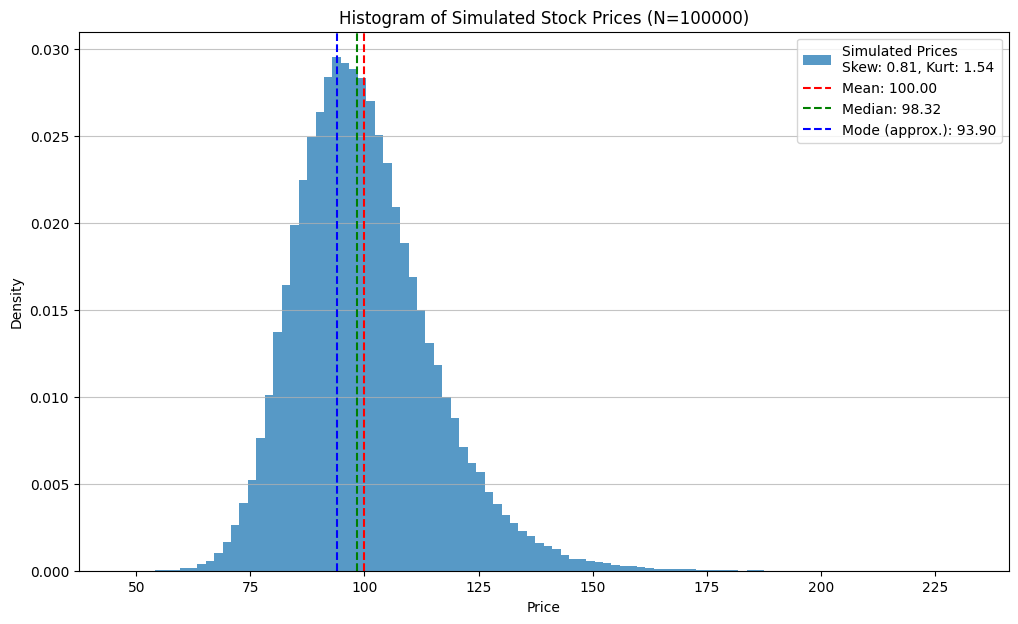


Successfully generated 100000 prices.


In [22]:
N_PRICES = 100000  # Number of data points to generate

# Define target moments
TARGET_MEAN = 100.0      # e.g., average stock price
TARGET_STD_DEV = 15.0    # e.g., price volatility
TARGET_SKEWNESS = 0.8    # Positive skew (long tail to the right)
                        # For negative skew, e.g. -0.5
TARGET_KURTOSIS_EXCESS = 1.5 # Leptokurtic (fatter tails than normal)
                            # Normal distribution has 0 excess kurtosis
                            # Platykurtic (thinner tails) would be negative, e.g. -0.5

# Note on Kurtosis:
# This code assumes 'target_kurtosis_excess' is Fisher's excess kurtosis.
# Pearson's kurtosis = Excess Kurtosis + 3.
# If you have Pearson's kurtosis, subtract 3 to get the excess kurtosis.
# The Johnson SU distribution requires: excess_kurtosis > skewness^2 - 2.
# Example: If skewness = 0.8, then kurtosis must be > (0.8^2 - 2) = (0.64 - 2) = -1.36.
# Our target_kurtosis_excess = 1.5, which is > -1.36, so it should be achievable.

print(f"Simulating {N_PRICES} stock prices with specified moments...")
simulated_prices_list, final_moments = simulate_stock_prices_with_moments(
    n_prices=N_PRICES,
    target_mean=TARGET_MEAN,
    target_std_dev=TARGET_STD_DEV,
    target_skewness=TARGET_SKEWNESS,
    target_kurtosis_excess=TARGET_KURTOSIS_EXCESS
)

if simulated_prices_list:
    print(f"\nSuccessfully generated {len(simulated_prices_list)} prices.")
    # print("First 10 simulated prices:", simulated_prices_list[:10])
else:
    print("Failed to generate stock prices.")

In [24]:
print(simulated_prices_list[10:])

[95.83360226294936, 109.59224228904799, 78.42784617419663, 89.21070688460136, 97.18342707173366, 92.8324740935762, 96.8914290113733, 85.49503676340836, 96.63268054206964, 88.37372494728278, 100.69593476309362, 108.63664282741055, 93.3337317770144, 107.71155325149813, 103.34620173749438, 124.148712470664, 103.59470898045709, 82.28713188773679, 105.22317511600411, 79.18755756175022, 130.39097020526484, 109.77595365643477, 98.93558995334763, 88.0014075452286, 78.30885276402384, 96.56760671143442, 82.80265090196104, 74.5406893097569, 93.89156637636172, 96.6394431271493, 81.80171758053527, 83.91067418159444, 91.54735911573579, 82.7250887252316, 97.70329393154502, 119.17352341702392, 119.64242668783282, 73.06418406991244, 100.63958382100512, 94.25580516459127, 103.7997975668886, 112.74001701056012, 105.25190439436416, 96.57965516161514, 115.86588933398099, 114.53363132832868, 108.46433755497661, 93.84140826694586, 98.25187524733904, 108.5948404753193, 91.82809966430695, 73.61484928434301, 11